# MEng-Team-Project-ML

This notebook contains the initial analysis of SQLite DB files generated \
by our ML system as of February 2022 (refer to git commit for exact \
version).

Each one of our key objectives is far easier to implement than before because\
the StrongSORT algorithm is very performant, and easy to calibrate for our use\
case.
- Object Identification 
  - This objective is the easiest to implement as we have the predicted \
    class along with it's bounding box per frame.
- Object Count
  - For this objective, we just count the number of unique IDs across time. The \
    lower the IDs (identity switching) and higher the AssA (association accuracy) \
    of our model for our dataset, the more reliable this object count will be, and \
    less post-processing of the analytics will be required.
- Object Tracking
  - For each object which is being successfully tracked and ID'd, we track its \
    detected anchor point from its bounding box across time and see which \
    boundaries of the video footage it's intersecting with, to \
    see which routes it's going from and to.

## Load Dataset

### Load COCO Classes

In [203]:
COCO_CLASSES = [ 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee',
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard',
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear',
         'hair drier', 'toothbrush' ]

### Load Pre-Saved Analytical Dataset (SQLite)

In [204]:
import os
from traffic_ml.lib.gdrive import get_gdrive_id, download_file_from_google_drive

TEST_FILE_FNAME = "test.db"
TEST_FILE_LINK  = "https://drive.google.com/file/d/1EEiUSRbU8ehg_UaOJ5x9ci8DTOD-TqrA/view?usp=sharing"

gdrive_id = get_gdrive_id(TEST_FILE_LINK)
out = download_file_from_google_drive(gdrive_id, f"./{TEST_FILE_FNAME}")

if os.path.exists(TEST_FILE_FNAME):
    print("Downloaded successfully!")
else:
    print(f"Error downloading: {TEST_FILE_FNAME}")

Downloaded successfully!


## Data Analysis

### Load Data into Dataframes

In [205]:
import sqlite3
import pandas as pd

# NOTE: Overwrite this for a local analysis
# TEST_FILE_FNAME = "00001.01350_2022-12-07T15-35-24.000Z.db"
con = sqlite3.connect(TEST_FILE_FNAME)

# Detected Objects per Frame
detections_df = pd.read_sql_query("SELECT * FROM detection;", con)

con.close()

DatabaseError: Execution failed on sql 'SELECT * FROM detection;': no such table: detection

### Change Frames to Timestamp

In [ ]:
import arrow 
STARTTIME = arrow.get('2022-12-07T153524') #Test timestamp
FPS = 25

def newTimestamp(timestamp, frame, fps):
    return timestamp.shift(microseconds=1000000/fps * frame)

# Test timestamp update
print(STARTTIME.format('YYYY-MM-DD HH:mm:ss.SSSSSS'))
print(newTimestamp(STARTTIME, 25, FPS).format('YYYY-MM-DD HH:mm:ss.SSSSSS'))

detections_df['timestamp'] = detections_df.apply(
    lambda row: newTimestamp(STARTTIME, int(row["frame"]), FPS), 
    axis=1
)

2022-12-07 15:35:24.000000
2022-12-07 15:35:25.000000


### Detection Count (per Frame)

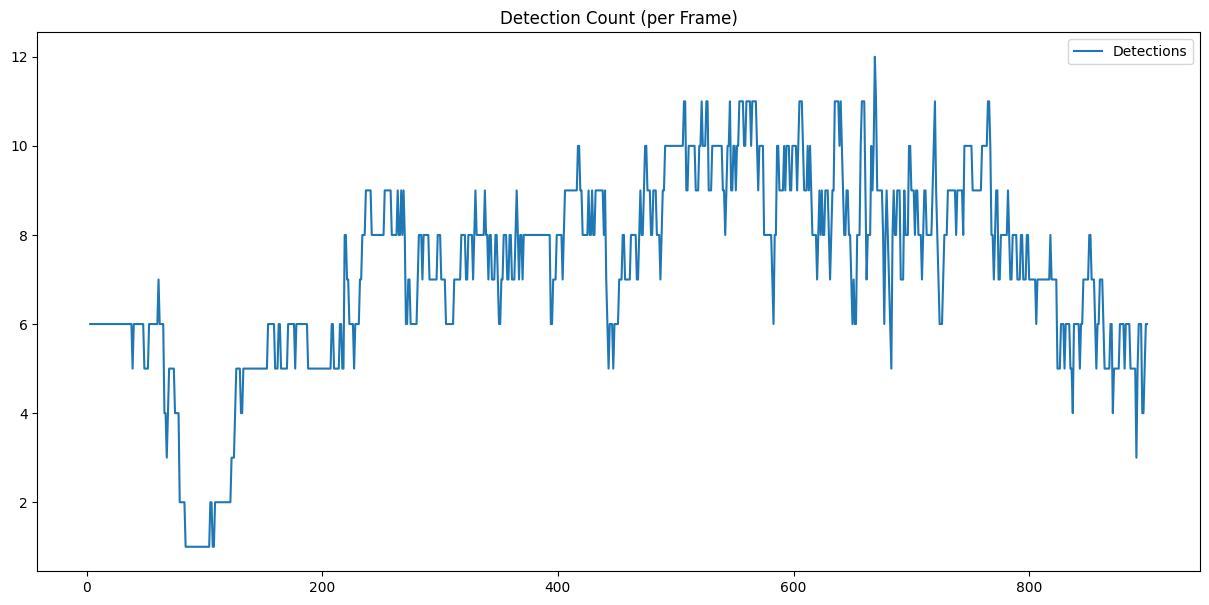

In [ ]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (15,7)

det_count = detections_df["frame"].value_counts().sort_index()

plt.title("Detection Count (per Frame)")
plt.plot(det_count, label="Detections")

plt.legend()

### Object Count

In [ ]:
data = detections_df

In [ ]:
counts = data.groupby('label')['det_id'].nunique().reset_index(name='count')

In [ ]:
counts

,label,count
0,bicycle,5
1,bird,1
2,bus,1
3,car,18
4,person,28
5,skateboard,4
6,traffic light,1
7,truck,6


### Object Tracking

In [ ]:
routes_df = data[["frame", "label", "det_id", "bbox_x", "bbox_y", "bbox_w", "bbox_h"]].copy()
routes_df["anchor_x"] = routes_df.apply(
    lambda row: row["bbox_x"] + (row["bbox_w"] / 2.0), axis=1)
routes_df["anchor_y"] = routes_df.apply(
    lambda row: row["bbox_y"] + (row["bbox_h"] / 2.0), axis=1)

#### Either First and Last, or all Anchor Points for Each (label, det_id) Tuple

In [ ]:
def get_values(group):
    return group[['anchor_x', 'anchor_y']].values.tolist()

entire_routes = routes_df.groupby(['label', 'det_id']).apply(get_values)

In [ ]:
entire_routes

label    det_id
bicycle  90.0      [[1057.5, 367.5], [1058.5, 368.0], [1061.5, 36...
         108.0     [[1212.5, 386.5], [1216.0, 388.0], [1222.0, 38...
         111.0     [[1278.5, 437.5], [1283.5, 439.0], [1288.0, 45...
         112.0                    [[1328.5, 403.0], [1332.0, 405.0]]
         117.0     [[1389.5, 412.5], [1396.0, 415.0], [1405.0, 41...
                                         ...                        
truck    5.0       [[285.0, 326.0], [285.5, 325.5], [285.0, 326.0...
         22.0      [[285.5, 325.0], [286.5, 325.0], [286.5, 324.0...
         41.0      [[284.5, 326.0], [286.5, 324.5], [285.0, 324.5...
         49.0      [[285.0, 326.5], [284.5, 325.5], [284.5, 327.0...
         74.0      [[840.5, 328.0], [843.5, 328.5], [845.5, 329.0...
Length: 64, dtype: object

In [ ]:
import json
trk_fmt = "first_last"

def get_values(group, trk_fmt):
    vals = group[['frame', 'anchor_x', 'anchor_y']].values.tolist()
    if trk_fmt == "first_last":
        vals = [vals[0], vals[-1]]
    vals = [{"frame:": val[0], "x": val[1], "y": val[2]} for val in vals]
    return vals

routes = routes_df.groupby(['label', 'det_id']).apply(
            lambda group: get_values(group, trk_fmt))

# Reset the index of the resulting series to remove the MultiIndex
routes = routes.reset_index()

# Replace the MultiIndex label column names with 'label' and 'det_id'
routes.rename(columns={0: 'routes'}, inplace=True)
routes.rename(columns={'level_0': 'label', 'level_1': 'det_id'}, inplace=True)

# Create a dictionary with 'label' as the key and 'routes' as the value
route_dict = routes.groupby('label')['routes'].apply(list).to_dict()

# Separate raw data and analytical data
final_data = {
    "counts": json.loads(counts.to_json(orient="records")),
    "routes": route_dict
}

In [ ]:
route_dict

{'bicycle': [[{'frame:': 654.0, 'x': 1057.5, 'y': 367.5},
   {'frame:': 682.0, 'x': 1150.5, 'y': 376.0}],
  [{'frame:': 696.0, 'x': 1212.5, 'y': 386.5},
   {'frame:': 722.0, 'x': 1337.5, 'y': 395.0}],
  [{'frame:': 713.0, 'x': 1278.5, 'y': 437.5},
   {'frame:': 732.0, 'x': 1421.5, 'y': 475.5}],
  [{'frame:': 719.0, 'x': 1328.5, 'y': 403.0},
   {'frame:': 720.0, 'x': 1332.0, 'y': 405.0}],
  [{'frame:': 728.0, 'x': 1389.5, 'y': 412.5},
   {'frame:': 767.0, 'x': 1757.5, 'y': 496.0}]],
 'bird': [[{'frame:': 105.0, 'x': 877.5, 'y': 544.5},
   {'frame:': 106.0, 'x': 840.0, 'y': 557.5}]],
 'bus': [[{'frame:': 3.0, 'x': 1754.5, 'y': 275.5},
   {'frame:': 130.0, 'x': 224.5, 'y': 532.0}]],
 'car': [[{'frame:': 3.0, 'x': 1616.0, 'y': 398.0},
   {'frame:': 61.0, 'x': 92.0, 'y': 838.5}],
  [{'frame:': 3.0, 'x': 800.0, 'y': 331.0},
   {'frame:': 78.0, 'x': 782.5, 'y': 331.0}],
  [{'frame:': 61.0, 'x': 187.0, 'y': 548.5},
   {'frame:': 78.0, 'x': 775.5, 'y': 436.0}],
  [{'frame:': 109.0, 'x': 1442.5,

### Object Routes

#### Route Region (Region Visualisation)

Following route regions for Park Rd East, Burnaby Rd South and Park Rd West, respectively (relative to junction)
<div>
<img src="route_regions.png" width="500"/>
</div>

#### Route Region (Polygon Data)

In [ ]:
ROUTE_REGIONS = {
    "e_park": [
        [
            701.000000000194,
            487.4999999987582
        ],
        [
            536.000000000194,
            307.49999999922386
        ],
        [
            515.0000000002716,
            73.49999999891345
        ],
        [
            102.00000000027163,
            62.49999999937912
        ],
        [
            101.00000000027163,
            1018.4999999989134
        ],
        [
            1307.000000000155,
            1011.4999999984477
        ],
        [
            701.000000000194,
            487.4999999987582
        ]
    ],
    "s_burnaby": [
        [
            551.000000000194,
            300.4999999984478
        ],
        [
            724.0000000005044,
            477.4999999984478
        ],
        [
            1118.0000000000775,
            380.4999999993791
        ],
        [
            1132.0000000004268,
            59.49999999937912
        ],
        [
            529.0000000005044,
            60.4999999984478
        ],
        [
            551.000000000194,
            300.4999999984478
        ]
    ],
    "w_park": [
        [
            1136.0000000002715,
            413.4999999996895
        ],
        [
            1815.000000000388,
            565.4999999992239
        ],
        [
            1817.0000000003104,
            61.49999999891346
        ],
        [
            1148.0000000002715,
            64.49999999891345
        ],
        [
            1136.0000000002715,
            413.4999999996895
        ]
    ],
    "n_burnaby": [
        [
            1814.0000000000775,
            578.4999999992239
        ],
        [
            1538.000000000155,
            508.49999999891344
        ],
        [
            1073.000000000194,
            794.499999999379
        ],
        [
            1351.000000000388,
            1009.4999999989134
        ],
        [
            1800.000000000388,
            1009.4999999989134
        ],
        [
            1814.0000000000775,
            578.4999999992239
        ]
    ]
}

### Object Tracking (Start and Finish Regions)

Total number of (start, end) tuples := n * (n - 1), where n is the number of unique route regions. \
For example in the image above, there are 3 route regions (Park W, Park E, Burnaby S). \
So the total number of unique paths for an object is 3 * (3 - 1) => 3 * 2 => 6.

In [ ]:
from shapely.geometry import Point, Polygon

# 1. Get start and end pos for each unique object during entire video
start_end_df = entire_routes.copy()
start_end_df = start_end_df.reset_index()

overlap_start_df = start_end_df.copy()[["label", "det_id"]]
overlap_end_df = start_end_df.copy()[["label", "det_id"]]

start_end_df["start_x"] = start_end_df.apply(lambda row: row[0][0][0],  axis=1)
start_end_df["start_y"] = start_end_df.apply(lambda row: row[0][0][1],  axis=1)
start_end_df["end_x"]   = start_end_df.apply(lambda row: row[0][-1][0], axis=1)
start_end_df["end_y"]   = start_end_df.apply(lambda row: row[0][-1][1], axis=1)
if 0 in start_end_df:
    del start_end_df[0]

# 2. Get overlaps between start and end, and each region
for route_region in ROUTE_REGIONS.keys():
    cur_polygon = Polygon(ROUTE_REGIONS[route_region])

    # Start Geometry
    start_geometry = [Point(x, y) for x, y in zip(start_end_df["start_x"], start_end_df["start_y"])]

    # Start Overlap
    start_end_df[f"{route_region}_start_overlap"] = [point.within(cur_polygon) for point in start_geometry]
    overlap_start_df[route_region]                = start_end_df[f"{route_region}_start_overlap"]

    # End Geometry
    end_geometry = [Point(x, y) for x, y in zip(start_end_df["end_x"], start_end_df["end_y"])]

    # End Overlap
    start_end_df[f"{route_region}_end_overlap"] = [point.within(cur_polygon) for point in end_geometry]
    overlap_end_df[route_region]                = start_end_df[f"{route_region}_end_overlap"]

In [ ]:
start_end_df

,label,det_id,start_x,start_y,end_x,end_y,e_park_start_overlap,e_park_end_overlap,s_burnaby_start_overlap,s_burnaby_end_overlap,w_park_start_overlap,w_park_end_overlap,n_burnaby_start_overlap,n_burnaby_end_overlap
0,bicycle,90.0,1057.5,367.5,1150.5,376.0,False,False,True,False,False,True,False,False
1,bicycle,108.0,1212.5,386.5,1337.5,395.0,False,False,False,False,True,True,False,False
2,bicycle,111.0,1278.5,437.5,1421.5,475.5,False,False,False,False,True,True,False,False
3,bicycle,112.0,1328.5,403.0,1332.0,405.0,False,False,False,False,True,True,False,False
4,bicycle,117.0,1389.5,412.5,1757.5,496.0,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,truck,5.0,285.0,326.0,284.0,325.0,True,True,False,False,False,False,False,False
60,truck,22.0,285.5,325.0,283.5,321.5,True,True,False,False,False,False,False,False
61,truck,41.0,284.5,326.0,285.5,323.5,True,True,False,False,False,False,False,False
62,truck,49.0,285.0,326.5,283.0,321.5,True,True,False,False,False,False,False,False


#### Determine (Start, End) Tuples

In [ ]:
overlap_start_df

,label,det_id,e_park,s_burnaby,w_park,n_burnaby
0,bicycle,90.0,False,True,False,False
1,bicycle,108.0,False,False,True,False
2,bicycle,111.0,False,False,True,False
3,bicycle,112.0,False,False,True,False
4,bicycle,117.0,False,False,True,False
...,...,...,...,...,...,...
59,truck,5.0,True,False,False,False
60,truck,22.0,True,False,False,False
61,truck,41.0,True,False,False,False
62,truck,49.0,True,False,False,False


#### Determine Start Label

In [ ]:
import numpy as np

def label_overlap(row):
    for i in range(len(row)):
        if row[i]:
            return overlap_start_df.columns[2:][i]
    return np.nan

overlap_start_df['overlap_label'] = overlap_start_df.iloc[:, 2:].apply(label_overlap, axis=1)

In [ ]:
overlap_start_df

,label,det_id,e_park,s_burnaby,w_park,n_burnaby,overlap_label
0,bicycle,90.0,False,True,False,False,s_burnaby
1,bicycle,108.0,False,False,True,False,w_park
2,bicycle,111.0,False,False,True,False,w_park
3,bicycle,112.0,False,False,True,False,w_park
4,bicycle,117.0,False,False,True,False,w_park
...,...,...,...,...,...,...,...
59,truck,5.0,True,False,False,False,e_park
60,truck,22.0,True,False,False,False,e_park
61,truck,41.0,True,False,False,False,e_park
62,truck,49.0,True,False,False,False,e_park


#### Determine End Label

In [ ]:
import numpy as np

def label_overlap(row):
    for i in range(len(row)):
        if row[i]:
            return overlap_end_df.columns[2:][i]
    return np.nan

overlap_end_df['overlap_label'] = overlap_end_df.iloc[:, 2:].apply(label_overlap, axis=1)

In [ ]:
overlap_end_df

,label,det_id,e_park,s_burnaby,w_park,n_burnaby,overlap_label
0,bicycle,90.0,False,False,True,False,w_park
1,bicycle,108.0,False,False,True,False,w_park
2,bicycle,111.0,False,False,True,False,w_park
3,bicycle,112.0,False,False,True,False,w_park
4,bicycle,117.0,False,False,True,False,w_park
...,...,...,...,...,...,...,...
59,truck,5.0,True,False,False,False,e_park
60,truck,22.0,True,False,False,False,e_park
61,truck,41.0,True,False,False,False,e_park
62,truck,49.0,True,False,False,False,e_park


#### Create Final Overlap DataFrame

In [ ]:
overlap_df = start_end_df.iloc[:, :2]
overlap_df["start"] = overlap_start_df["overlap_label"]
overlap_df["end"]   = overlap_end_df["overlap_label"]

In [ ]:
overlap_df

,label,det_id,start,end
0,bicycle,90.0,s_burnaby,w_park
1,bicycle,108.0,w_park,w_park
2,bicycle,111.0,w_park,w_park
3,bicycle,112.0,w_park,w_park
4,bicycle,117.0,w_park,w_park
...,...,...,...,...
59,truck,5.0,e_park,e_park
60,truck,22.0,e_park,e_park
61,truck,41.0,e_park,e_park
62,truck,49.0,e_park,e_park
